In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
import time, math, sys
from IPython.utils import io
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'
from classy import Class

sys.path.insert(1, '/home/joeadamo/Research')
from DarkEmuPowerRSD import pkmu_hod
from CovNet import CovNet, CovaPT

In [2]:
# IMPORTANT: Make sure the parameters here are the same as when you trained the network in question!
N = 43000
N_test = int(N*0.1)
train_log = True
train_gaussian = False
train_cholesky = True
training_dir = "/home/joeadamo/Research/CovNet/Data/Training-Set-NG/"
#training_dir = "/home/jadamo/CovNet/Data/Training-Set/"
save_dir = "/home/joeadamo/Research/CovNet/Plots/"
#save_dir = "/home/jadamo//CovNet/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
#BOSS_dir = "/home/jadamo/CovNet/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"
#CovaPT_dir = "/home/jadamo/CovaPT/Example-Data/"
if train_gaussian: net_dir = "../Data/Gaussian/"
if train_cholesky: net_dir = "../Data/Cholesky-decomp/"
else:              net_dir = "../Data/Non-Gaussian/"
k =np.loadtxt(CovaPT_dir+'k_Patchy.dat')

In [3]:
params_fid = np.array([67.8,0.1190,0.02215,3.094,1.9485,-0.5387])
#Pk_fid = CovaPT.Pk_gg(params_fid, pgg)
Pk_fid = CovaPT.Pk_CLASS_PT(params_fid)
data_vector = np.concatenate([Pk_fid[0], Pk_fid[2]])

def gaussian_covariance(params, i, offset):
    """
    Loads the model vector and gaussian covariance from file if it exists, otherwise calculates it
    """
    idx = i + offset
    data = np.load(training_dir+"CovA-"+f'{idx:05d}'+".npz")
    np.testing.assert_allclose(params, data["params"])
    try:
        return data["model"], data["C_G"]
    except:
        Pk_galaxy = CovaPT.Pk_CLASS_PT(params)
        model_vector = np.concatenate([Pk_galaxy[0], Pk_galaxy[2]])
        C_G = data["C_G"]; C_NG = data["C_NG"]
        np.savez(training_dir+"CovA-"+f'{idx:05d}'+".npz", params=data["params"], model=model_vector, C_G=C_G, C_NG=C_NG)
        return model_vector, C_G

In [4]:
# load the trained network
#net = CovNet.Network_Full(6, 100*100)
net = CovNet.Network_VAE(train_cholesky).to(CovNet.try_gpu());       net.eval()
encoder = CovNet.Block_Encoder().to(CovNet.try_gpu()); encoder.eval()
decoder = CovNet.Block_Decoder(train_cholesky).to(CovNet.try_gpu()); decoder.eval()
net_2 = CovNet.Network_Features(6, 10).to(CovNet.try_gpu())
net.load_state_dict(torch.load(net_dir+'network-VAE.params'))
encoder.load_state_dict(net.Encoder.state_dict())
decoder.load_state_dict(net.Decoder.state_dict())
net_2.load_state_dict(torch.load(net_dir+'network-latent.params'))

<All keys matched successfully>

In [5]:
# load the test set
t1 = time.time()
test_data = CovNet.MatrixDataset(training_dir, N_test, int(N*0.9), train_log, train_gaussian, train_cholesky)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 4.02 s


In [6]:
# get the L1 loss for the matrix -> latent -> matrix and params -> latent -> matrix pipelines
loss_data_1 = np.zeros(N_test)
loss_data_2 = np.zeros(N_test)
num_NaN = 0
net.eval()
for i in tqdm(range(N_test)):
    params = test_data[i][0]; 
    C_actual = test_data[i][1]

    C_reconstruct, mu, log_var = net(C_actual.view(1, 100, 100))
    C_predict = decoder(net_2(params).view(1,10)).view(100,100)
    if True in torch.isnan(C_predict):
        num_NaN += 1
    
    loss_data_1[i] = F.l1_loss(C_reconstruct.view(100,100), C_actual, reduction="sum")
    loss_data_2[i] = F.l1_loss(C_predict, C_actual, reduction="sum")
    
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data_1), np.amax(loss_data_1), np.mean(loss_data_1)))
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data_2), np.amax(loss_data_2), np.mean(loss_data_2)))
print(num_NaN, "matrices have NaNs")

100%|██████████████████████████████████████| 4300/4300 [00:30<00:00, 143.05it/s]

min loss: 49.549, max loss 1983.482, avg loss: 247.434
min loss: 53.549, max loss 2311.305, avg loss: 271.719
0 matrices have NaNs


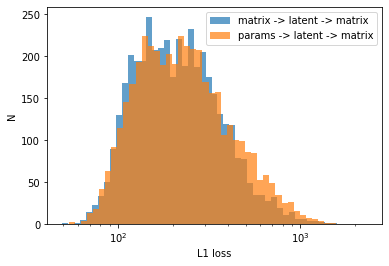

In [7]:
plt.hist(loss_data_1, alpha=0.7, label="matrix -> latent -> matrix", bins=np.logspace(np.log10(np.amin(loss_data_1)), np.log10(np.amax(loss_data_1)), 50))
plt.hist(loss_data_2, alpha=0.7, label="params -> latent -> matrix", bins=np.logspace(np.log10(np.amin(loss_data_2)), np.log10(np.amax(loss_data_2)), 50))
plt.xlabel("L1 loss")
plt.ylabel("N")
plt.legend()
plt.xscale("log")

In [8]:
# get the chi squared differences using this network
# This cell takes ~ 1 hour to run
chi_squared_err = np.zeros(N_test)
chi_squared_actual = np.zeros(N_test)
non_definete = []; avg_bad = 0
for i in tqdm(range(N_test)):
    params = test_data[i][0]; C_actual = test_data[i][1]
    features = net_2(params); C_predict = decoder(features.view(1,10))
    #C_actual = CovNet.symmetric_exp(C_actual)
    #C_predict = CovNet.symmetric_exp(C_predict)
    
    with io.capture_output() as captured:
        model_vector, C_G = gaussian_covariance(params.detach().numpy(), i, int(N*0.9))
    if train_cholesky == False:
        C_actual = C_G + C_actual.view(100,100).detach().numpy()
        C_predict = C_G + C_predict.view(100,100).detach().numpy()
        
        P_actual = np.linalg.inv(C_actual)
        P_predict = np.linalg.inv(C_predict)
    else:
        L_actual = CovNet.symmetric_exp(C_actual).view(100,100).detach().numpy()
        L_predict = CovNet.symmetric_exp(C_predict).view(100,100).detach().numpy()
            
        C_actual = np.matmul(L_actual, L_actual.T)
        C_predict = np.matmul(L_predict, L_predict.T)
        P_actual = np.linalg.inv(C_actual)
        P_predict = np.linalg.inv(C_predict)
    
    eigen, v = np.linalg.eig(P_actual)
    if np.all(eigen >= 0.) == False:
        non_definete.append(i)
        avg_bad += len(eigen[(eigen < 0)])
    
    x = data_vector - model_vector
    chi_squared_1 = np.matmul(x.T, np.matmul(P_predict, x))
    chi_squared_2 = np.matmul(x.T, np.matmul(P_actual, x))
    chi_squared_err[i] = abs(chi_squared_1 - chi_squared_2)
    chi_squared_actual[i] = chi_squared_2
    
print("chi squared absolute errors: [{:0.2f}, {:0.2f}], avg = {:0.3f}".format(np.amin(chi_squared_err), np.amax(chi_squared_err), np.mean(chi_squared_err)))
if len(non_definete) != 0:
    print(len(non_definete), "Matrices don't have all positive eigenvalues, avg number of bad eigenvalues:", avg_bad / len(non_definete))

100%|███████████████████████████████████████| 4300/4300 [04:31<00:00, 15.82it/s]

chi squared absolute errors: [0.02, 19993725.91], avg = 23609.095


0
1357 (31.56)% of matrices have chi squared errors better than 10%!


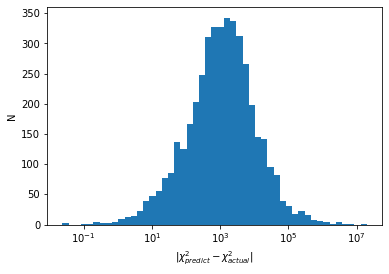

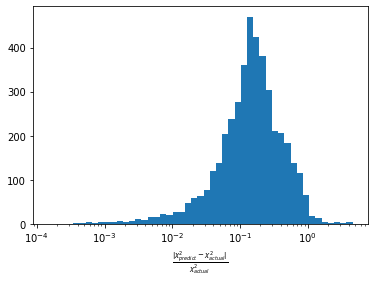

In [9]:
plt.hist(chi_squared_err, bins=np.logspace(np.log10(np.amin(chi_squared_err[(chi_squared_err != 0)])), np.log10(np.amax(chi_squared_err)), 50))
plt.xlabel(r"$|\chi_{predict}^2 - \chi_{actual}^2|$")
plt.ylabel("N")
plt.xscale("log")

chi_squared_valid = chi_squared_actual[(chi_squared_actual >= 0)]
print(len(chi_squared_actual) - len(chi_squared_valid))
chi_squared_rel_err = chi_squared_err / chi_squared_actual
num = len(chi_squared_rel_err[(chi_squared_rel_err <= 0.1)])
print("{:0d} ({:0.2f})% of matrices have chi squared errors better than 10%!".format(num, 100.*num/N_test))

chi_squared_rel_err_1 = chi_squared_rel_err[(chi_squared_rel_err >= 0)]
plt.figure()
plt.hist(chi_squared_rel_err_1, bins=np.logspace(np.log10(np.amin(chi_squared_rel_err_1)), np.log10(np.amax(chi_squared_rel_err_1)), 50))
plt.xlabel(r"$\frac{|\chi_{predict}^2 - \chi_{actual}^2|}{\chi_{actual}^2}$")
plt.xscale("log")

In [10]:
def make_heatmap(x, y, z, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.linspace(np.amin(y), np.amax(y), bins+1)
    z_new = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            z_new[j,i] = np.mean(z[(x >= x_new[i]) & (x < x_new[i+1]) & (y >= y_new[j]) & (y < y_new[j+1])])
    
    return x_new, y_new, z_new

def make_diagonal(x, y, bins):
    x_new = np.linspace(np.amin(x), np.amax(x), bins+1)
    y_new = np.zeros(bins)
    for i in range(bins):
        y_new[i] = np.mean(y[(x >= x_new[i]) & (x <= x_new[i+1])])
    return x_new[:bins], y_new

def plot_chi_squared_heatmap(params, chi_squared, label, extents):
    names = ['H0', 'omch2', 'ombh2', "As", "b1", "b2", "chi_squared"]
    labels= [r"$H_0$", r'$\omega_{cdm}$', r'$\omega_b$', r"$A_s$", "$b1$", "$b2$", label]

    fig, axs = plt.subplots(6,6, figsize=(14,14))
    for i in range(6):
        for j in range(6):
            if i < j:
                axs[i][j].axis("off")
                continue
            if i == j:
                x, y = make_diagonal(params[:,j], chi_squared, 30)
                #axs[i][j].axhline(0, color="red")
                axs[i][j].plot(x, y)
            else:
                #X, Y, Z = make_heatmap(params[:,j], params[:,i], chi_squared, 30)
                #img = axs[i,j].imshow(Z, aspect="auto", extent=(X[0], X[-1], Y[0], Y[-1]), cmap="coolwarm", 
                #                     norm=colors.LogNorm(vmin=extents[0], vmax=extents[1]))
                #axs[i,j].set_xlim(X[0] - (X[-1] - X[0]) * 0.05, X[-1] + (X[-1] - X[0]) * 0.05)
                #axs[i,j].set_ylim(Y[0] - (Y[-1] - Y[0]) * 0.05, Y[-1] + (Y[-1] - Y[0]) * 0.05)
                img = axs[i][j].scatter(params[:,j], params[:,i], c=chi_squared, s=1, alpha=0.8, cmap="coolwarm",
                                        norm=colors.LogNorm(vmin=extents[0], vmax=extents[1]))
            if i != j: axs[i][j].axhline(params_fid[i], linestyle="--", c="black")
            axs[i][j].axvline(params_fid[j], linestyle="--", c="black")
            if i == 5: axs[i][j].set_xlabel(labels[j])
            if j == 0 and i != 0: axs[i][j].set_ylabel(labels[i])
            if j == 0 and i != 5:   axs[i][j].xaxis.set_ticklabels([])
            elif j != 0 and i == 5: axs[i][j].yaxis.set_ticklabels([])
            elif j != 0 and i != 5:
                axs[i][j].xaxis.set_ticklabels([])
                axs[i][j].yaxis.set_ticklabels([])

    cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_label(labels[-1] ,size=20)
    cbar.ax.tick_params(labelsize=15) 
    plt.subplots_adjust(wspace=0, hspace=0)
#plt.tight_layout(

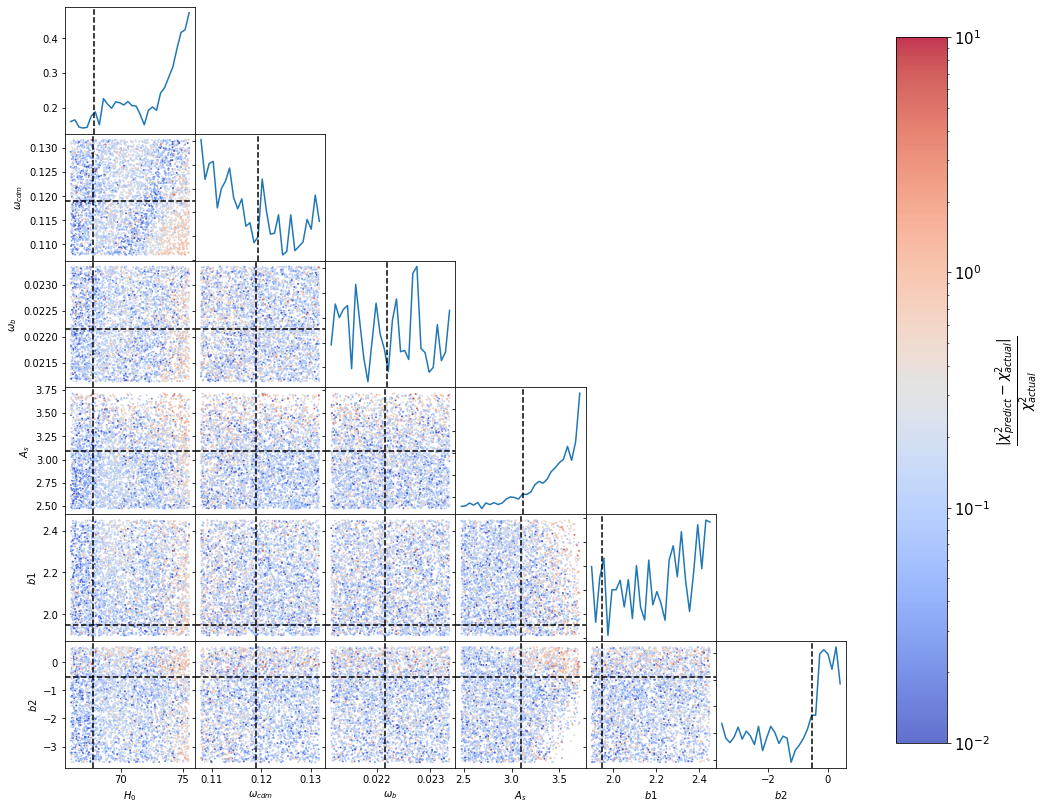

In [11]:
params = test_data[:][0].detach().numpy()
plot_chi_squared_heatmap(params, chi_squared_rel_err, r"$\frac{|\chi_{predict}^2 - \chi_{actual}^2|}{\chi_{actual}^2}$", [1e-2, 1e1])

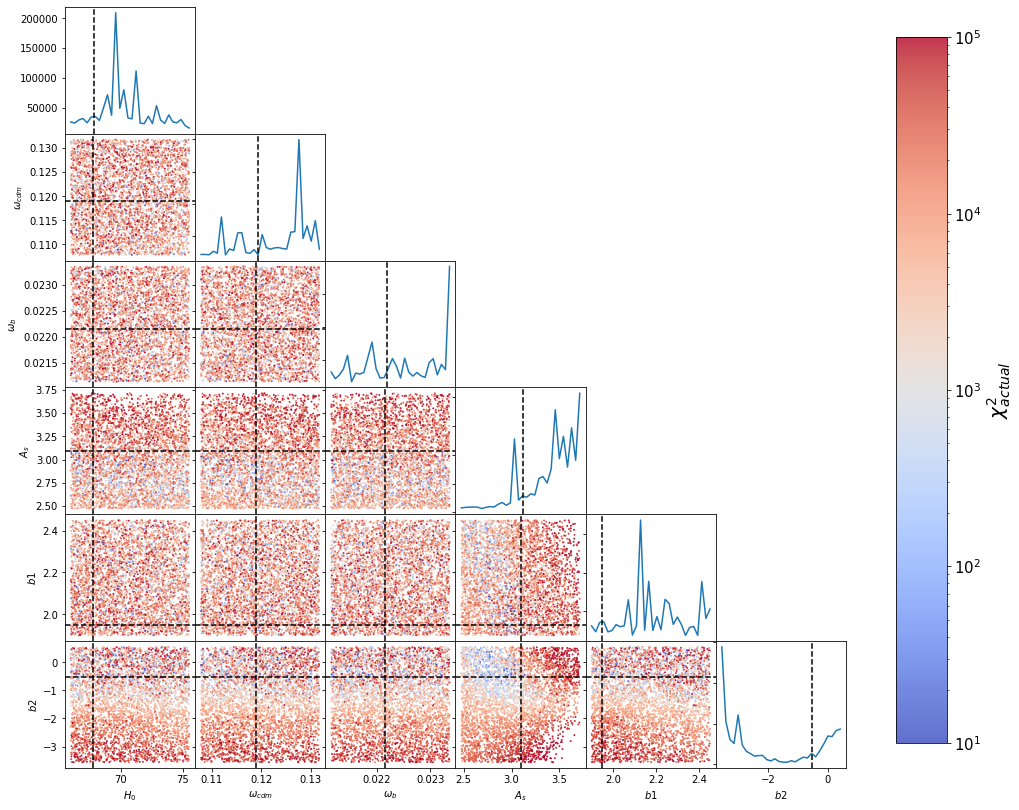

In [12]:
plot_chi_squared_heatmap(params, chi_squared_actual, r"$\chi_{actual}^2$", [1e1, 1e5])

In [13]:
# do a PCA on the whole training set, treating each covariance matrix as a single realization
data_predict = np.zeros((N_test, 100*100))
data_actual  = np.zeros((N_test, 100*100))

for i in tqdm(range(N_test)):
    params = test_data[i][0]; C_actual = test_data[i][1].view(100,100)
    C_predict = decoder(net_2(params).view(1,10)).view(100, 100)
    
    # if train_cholesky == False:
    #     C_predict = CovNet.symmetric_exp(C_predict).detach().numpy()
    C_predict = C_predict.detach().numpy()
    C_actual = C_actual.detach().numpy()
    
    data_predict[i] = C_predict.flatten()
    data_actual[i] = C_actual.flatten()

pca = PCA(n_components = 100)
# find the principal axes (basis vectors) of the testing set
pca.fit(data_actual)
# now project both the testing set and the prediced matrices set onto those basis vectors
components_predict = pca.transform(data_predict)
components_actual = pca.transform(data_actual)

100%|██████████████████████████████████████| 4300/4300 [00:10<00:00, 424.96it/s]


0.9987326304184971
[6461.19358004 5670.61779087 5630.05208295 9490.0115877  7091.17477334
 8792.51849325 3119.41745046 2974.62170587 4285.77804493 2911.84367403]


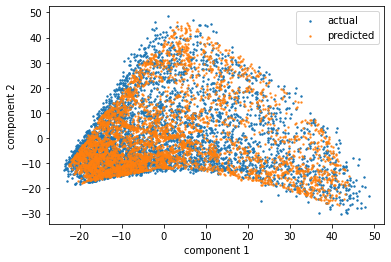

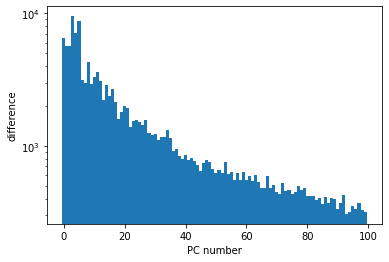

In [14]:
print(np.sum(pca.explained_variance_ratio_[:100]))
PCA_diff = np.sum(abs(components_predict - components_actual), axis=0)
print(PCA_diff[:10])

plt.scatter(components_actual[:, 0], components_actual[:, 1], s=2, label="actual")
plt.scatter(components_predict[:, 0], components_predict[:, 1], s=2, alpha=0.8, label="predicted")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.legend()

plt.figure()
plt.bar(range(100), PCA_diff[:100], width=1)
plt.xlabel("PC number")
plt.ylabel("difference")
plt.yscale("log")

final training loss: tensor(0.)


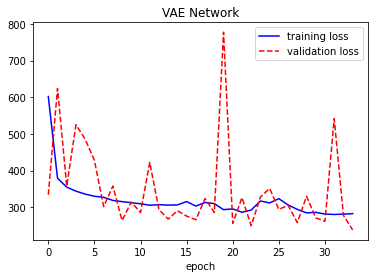

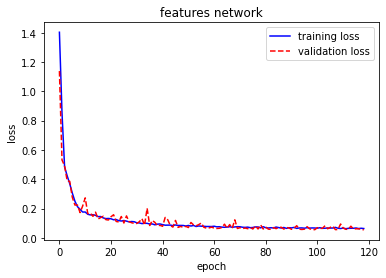

In [15]:
# visualize the training and validation loss
train_loss = torch.load(net_dir+"train_loss.dat")
valid_loss = torch.load(net_dir+"valid_loss.dat")
train_loss_f = torch.load(net_dir+"train_loss-latent.dat")
valid_loss_f = torch.load(net_dir+"valid_loss-latent.dat")

print("final training loss:", train_loss[-1])

epoch = range(len(train_loss[(train_loss != 0)]))
plt.title("VAE Network")
plt.plot(epoch, train_loss[(train_loss != 0)], color="blue", label="training loss")
plt.plot(epoch, valid_loss[(valid_loss != 0)], color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
#plt.ylabel("loss")
#plt.ylim(200, 2000)
#plt.yscale("log")
plt.legend()

epoch_f = range(len(train_loss_f[(train_loss_f != 0)]))
plt.figure()
plt.title("features network")
plt.plot(epoch_f, train_loss_f[(train_loss_f != 0)], color="blue", label="training loss")
plt.plot(epoch_f, valid_loss_f[(train_loss_f != 0)], color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.yscale("log")
plt.legend(
)

In [16]:
# try to visualize the latent feature space
features = torch.zeros(N, 10, device=CovNet.try_gpu())
t1 = time.time()
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    z, mu, log_var = encoder(matrix.view(1, 100, 100))
    features[i] = z
    
features = features.to("cpu").detach().numpy()
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))

Done!, took 0 minutes 10.12 seconds


[ 7.2822452e-01  5.6537175e-01  3.4999251e-01  1.1856079e+00
  8.4678406e-01  1.0052847e+00  5.2179283e-01  5.0691658e-01
  1.1770110e+00 -9.2768506e-04]


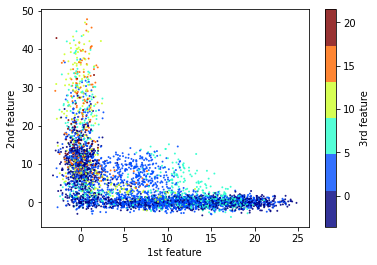

In [17]:
N_colors = 6 # <- number of colors
base = plt.cm.get_cmap("jet")
color_list = base(np.linspace(0, 1, N_colors))
cmap_name = base.name + str(N)
cmap = base.from_list(cmap_name, color_list, N_colors)

print(np.mean(features, axis=0))
f1 = 0; f2 = 1; f3 = 2
plt.scatter(features[:,f1], features[:,f2], cmap=cmap, c=features[:,f3], alpha=0.8, s=1)
plt.xlabel("1st feature")
plt.ylabel("2nd feature")
cbar = plt.colorbar()
cbar.set_label("3rd feature")

### Tests on individual matrices

Indexes: 3266 4129


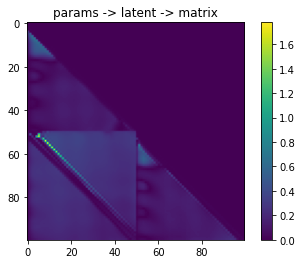

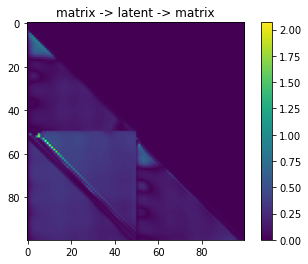

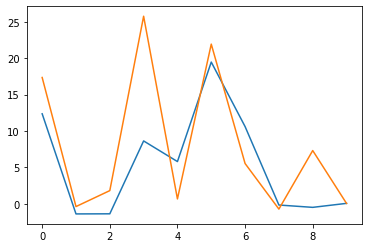

In [18]:
# Let's first confirm that seperate parameter imputs give different outputs
# if the resulting plot is all zeros, that may suggest posterior collapse of the network
idx1 = np.random.randint(0, N_test); idx2 = np.random.randint(0, N_test)
params1 = test_data[idx1][0]; params2 = test_data[idx2][0]
cov_actual1 = test_data[idx1][1]; cov_actual2 = test_data[idx2][1]

cov_reconstruct1, mu, var = net(cov_actual1.view(1,100,100))
cov_reconstruct2, mu, var = net(cov_actual2.view(1,100,100))

features = net_2(params1); cov_predict1 = decoder(features.view(1,10)).view(100, 100).to("cpu").detach()
features_2 = net_2(params2); cov_predict2 = decoder(features_2.view(1,10)).view(100, 100).to("cpu").detach()

# If this plot has mostly 0's everywhere than the network isn't distiguishing between cosmologies!
print("Indexes:", idx1, idx2)
plt.title("params -> latent -> matrix")
plt.imshow(abs(cov_predict1 - cov_predict2))
cbar = plt.colorbar()

plt.figure()
plt.title("matrix -> latent -> matrix")
plt.imshow(abs(cov_reconstruct1 - cov_reconstruct2).view(100,100).detach().numpy())
cbar = plt.colorbar()

plt.figure()
plt.plot(range(10), features.view(10).detach().numpy())
plt.plot(range(10), features_2.view(10).detach().numpy())

tensor([6.8016e+01, 1.1779e-01, 2.3126e-02, 3.3975e+00, 2.0325e+00, 2.6530e-01])
loss =  1029.8935546875
latent loss = tensor(1.5949, grad_fn=<MeanBackward0>)
reduction = 183.103, KL Divergence = 846.790
sample 3185, params: tensor([6.8016e+01, 1.1779e-01, 2.3126e-02, 3.3975e+00, 2.0325e+00, 2.6530e-01])


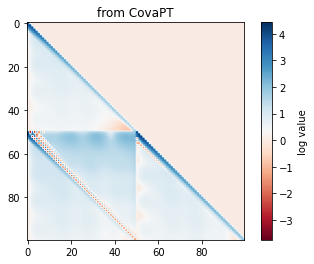

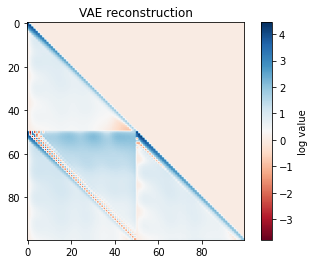

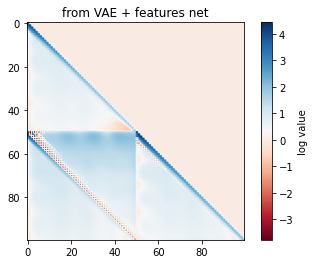

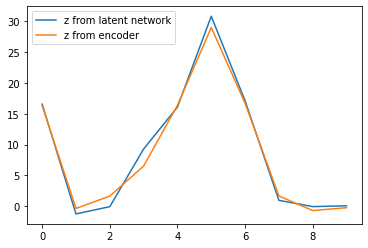

In [19]:
# Let's do some more detailed analysis on a random matrix from the test set
idx = np.random.randint(0, N_test)
#idx = 0
params = test_data[idx][0]
print(params)
# matrix from CovaPT
cov_actual = test_data[idx][1]
# matrix from VAE reconstruction
cov_VAE, mu, log_var = net(cov_actual.view(1,100,100)); cov_VAE = cov_VAE.view(100,100)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,10)).view(100, 100)
features_VAE, mu, log_var = encoder(cov_actual.view(1,100,100))

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("loss = ", CovNet.VAE_loss(cov_VAE.view(1,100,100), cov_actual.view(1,100,100), mu, log_var).item())
print("latent loss =", CovNet.features_loss(features, features_VAE))
print("reduction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
#cov_actual = CovNet.symmetric_exp(cov_actual)
# cov_VAE = CovNet.symmetric_exp(cov_VAE)
# cov_predict = CovNet.symmetric_exp(cov_predict)

cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu")#, vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(cov_predict, cmap="RdBu")#, vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.plot(range(10), features.view(10).detach().numpy(), label="z from latent network")
plt.plot(range(10), features_VAE.view(10).detach().numpy(), label="z from encoder")
#plt.plot(range(10), mu.view(10).detach().numpy(), label="mu from encoder")
plt.legend()

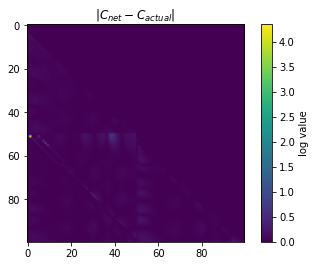

In [20]:
# Visualize the difference between generated and actual matrix
C_residual = abs(cov_predict - cov_actual)
plt.title(r"$|C_{net} - C_{actual}|$")
plt.imshow(C_residual)
cbar = plt.colorbar()
cbar.set_label("log value")

diagonal is all positive: True
matrix is symmetric: True
matrix is positive definite!
eigenvalues all positive: True


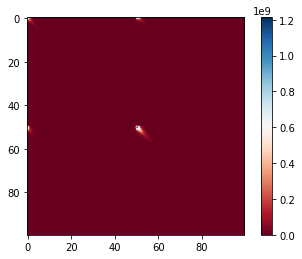

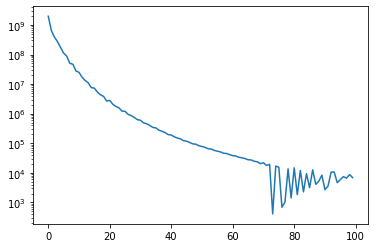

In [21]:
# Test for positive definite-ness
if train_cholesky == False:
    model_vector, C_G = gaussian_covariance(params.detach().numpy(), idx, int(N*0.9))
    C = C_G + cov_predict.detach().numpy()
else:
    L = CovNet.symmetric_exp(cov_predict).detach().numpy()
    C = np.matmul(L, L.T)
    
pos_diag = True
for i in range(C.shape[0]):
    if C[i,i] <= 0:
        pos_diag = False
print("diagonal is all positive:", pos_diag)

try:
    np.testing.assert_allclose(C, C.T, err_msg="covariance must match transpose")
    print("matrix is symmetric: True")
except AssertionError:
    print("matrix is symmetric: False")
try:
    L = np.linalg.cholesky(C)
    print("matrix is positive definite!")
except:
    print("matrix is NOT positive definite!")
    
eigen, v = np.linalg.eig(C)
print("eigenvalues all positive:", np.all(eigen >= 0.))

plt.imshow(C, cmap="RdBu")
plt.colorbar()

plt.figure()
plt.plot(range(len(eigen)), eigen)
plt.yscale("log")

## Extra tests for debugging

-616634.1 818910340.0


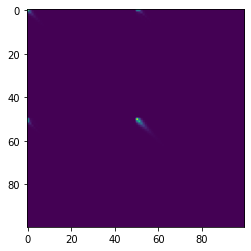

In [22]:
# TEMP: Galaxy power spectrum stuff
params_test = torch.tensor([ 6.9121e+01, 1.1103e-01, 2.1269e-02, 2.5061e+00, 1.9583e+00, -8.7879e-02])

L = decoder(net_2(params_test).view(1,10)).view(100, 100)
assert not True in torch.isnan(L)
L = CovNet.symmetric_exp(L).detach().numpy()
C = np.matmul(L, L.T)
print(np.amin(C), np.amax(C))

L_2 = np.linalg.cholesky(C)

plt.imshow(C)

In [29]:
params_fid = np.array([67.8,0.1190,0.02215,3.7,2.4,0.5])
C_G = CovaPT.get_gaussian_covariance(params_fid)
C_SSC, C_T0 = CovaPT.get_non_gaussian_covariance(params_fid)
C_fid = C_G + C_SSC + C_T0

try:
    L = np.linalg.cholesky(C_fid)
    print("Covariance matrix is positive-definite :")
except np.linalg.LinAlgError as err:
    print("Covariance matrix is NOT positive-definite!")
    
np.savez("../Data/Cov_Fid_Far.npz", C_G=C_G, C_SSC=C_SSC, C_T0=C_T0)

/home/joeadamo/Research/CovNet/CovaPT.py:429: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp2[i]=quad(lambda q: q**2*Plin(q)*Pwin(q)/2/pi**2, 0, kwin[-1], limit=100)[0]
/home/joeadamo/Research/CovNet/CovaPT.py:427: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

Covariance matrix is positive-definite :


Covariance matrix is NOT positive-definite!
0 [7.18362695e+03 7.19059668e+03 7.55834521e+03 7.94499951e+03
 9.57132422e+03 1.02379668e+04 1.09869316e+04 1.27405283e+04
 1.30548438e+04 1.53778545e+04 1.51437949e+04 1.89646465e+04
 2.13775039e+04 2.35159863e+04 2.75487402e+04 3.16310645e+04
 3.53781953e+04 4.03541992e+04 4.54451445e+04 5.23764727e+04
 5.87813516e+04 6.52881094e+04 7.73233203e+04 8.80368516e+04
 9.69318906e+04 1.14421938e+05 1.26056922e+05 1.53106312e+05
 1.74928562e+05 2.02222938e+05 2.66657188e+05 3.27949219e+05
 4.08536156e+05 5.26840000e+05 7.60057438e+05 1.02702300e+06
 1.24598762e+06 1.54583600e+06 2.30900600e+06 3.04378375e+06
 4.13678800e+06 5.90074100e+06 9.48857200e+06 1.49219810e+07
 2.53731440e+07 5.34657240e+07 9.23617120e+07 2.02452464e+08
 4.81080832e+08 9.69545472e+08 2.61048438e+03 3.10014185e+03
 3.41167383e+03 3.76308228e+03 3.92187622e+03 3.95848511e+03
 4.84443604e+03 5.08696143e+03 5.47076855e+03 5.89653320e+03
 6.74420752e+03 7.48801758e+03 8.155697

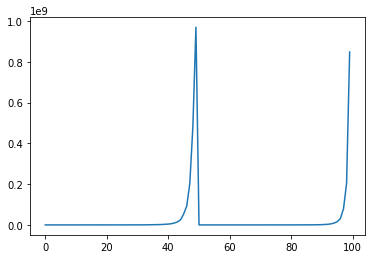

In [25]:
params_bad = torch.tensor([74.65041619539261, 0.1152447252368927, 0.0228745732113719, 3.696852154016495, 1.9854176259040832,-2.1415713782310486])
features = net_2(params_bad); C_bad = decoder(features.view(1,10)).view(100, 100)
C_bad = CovNet.corr_to_cov(C_bad).detach().numpy()

try:
    L = np.linalg.cholesky(C_bad)
except np.linalg.LinAlgError as err:
    print("Covariance matrix is NOT positive-definite!")

eigen, v = np.linalg.eig(C_bad)
print(len(eigen[(eigen < 0)]), eigen)
plt.plot(range(100), eigen)

In [26]:
# test to see what outputs from the training / validation sets looks like
# I'm only loading in a subset of the whole training set to save memory / time
t1 = time.time()
train_data = MatrixDataset(training_dir, int(N*0.1), 0, train_log, train_gaussian, train_cholesky)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

NameError: name 'MatrixDataset' is not defined

In [ ]:
idx = np.random.randint(0, N*0.1)
params = train_data[idx][0]
# matrix from CovaPT
cov_actual = train_data[idx][1]

cov_VAE, mu, log_var = net(cov_actual.view(1,100,100)); cov_VAE = cov_VAE.view(100,100)
# matrix from parameters -> features and features -> matrix
features = net_2(params); cov_predict = decoder(features.view(1,10)).view(100, 100)

RLoss = F.l1_loss(cov_VAE, cov_actual, reduction="sum")
KLD = 0.5 * torch.sum(log_var.exp() - log_var - 1 + mu.pow(2))

print("loss = ", VAE_loss(cov_VAE, cov_actual, mu, log_var).item())
print("rediction = {:0.3f}, KL Divergence = {:0.3f}".format(RLoss, KLD)) 
print("sample " + str(idx) + ", params:", params)
cov_VAE = cov_VAE.to("cpu").detach(); cov_predict = cov_predict.to("cpu").detach(); cov_actual = cov_actual.to("cpu").detach();

plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("VAE reconstruction")
plt.imshow(cov_VAE, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE + features net")
plt.imshow(cov_predict, cmap="RdBu", vmin=torch.amin(cov_actual), vmax=torch.amax(cov_actual))
cbar = plt.colorbar()
cbar.set_label("log value")